In [ ]:
import os, json
from pathlib import Path
import numpy as np
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
try:
    import seaborn as sns
    sns.set(style='whitegrid')
except Exception:
    sns = None

from sklearn.metrics import classification_report, confusion_matrix

KAGGLE_INPUT = Path('/kaggle/input')
KAGGLE_WORK  = Path('/kaggle/working')

print('TensorFlow:', tf.__version__)
print('INPUT exists:', KAGGLE_INPUT.exists(), '| WORKING:', KAGGLE_WORK.exists())


TensorFlow: 2.18.0
INPUT exists: True | WORKING: True


In [ ]:
class _DTypePolicyShim:
    def __init__(self, name="float32", **kwargs):
        self._name = name
    def __call__(self, *a, **k):
        return mixed_precision.Policy(self._name)

get_custom_objects().update({
    'DTypePolicy': _DTypePolicyShim,
    'dtype_policy': _DTypePolicyShim,
})


mixed_precision.set_global_policy('float32')


In [ ]:
MODEL_DIR = Path("/kaggle/input/alexnet-fer2013-keras/keras/default/1")
DATA_ROOT = Path("/kaggle/input/fer2013")                                
TEST_DIR  = DATA_ROOT / "test"
TRAIN_DIR = DATA_ROOT / "train"  

print("Exists | MODEL_DIR :", MODEL_DIR.exists())
print("Exists | TEST_DIR  :", TEST_DIR.exists())
print("Exists | TRAIN_DIR :", TRAIN_DIR.exists())
if TEST_DIR.exists():
    sub = sorted([p.name for p in TEST_DIR.iterdir() if p.is_dir()])
    print("Test class folders:", sub)


Exists | MODEL_DIR : True
Exists | TEST_DIR  : True
Exists | TRAIN_DIR : True
Test class folders: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [ ]:
def build_idg_iterator_from_dir(root_dir, target_size, batch_size=64):
    idg = ImageDataGenerator(rescale=1/255.)
    gen = idg.flow_from_directory(
        root_dir,
        target_size=target_size,
        batch_size=batch_size,
        shuffle=False,              
        class_mode='categorical'
    )
    return gen


In [ ]:
if not MODEL_DIR.exists():
    raise FileNotFoundError(f"MODEL_DIR not found: {MODEL_DIR}")

savedmodel_pb = MODEL_DIR / "saved_model.pb"
USE_SAVEDMODEL_DIR = savedmodel_pb.exists()  

if USE_SAVEDMODEL_DIR:
    model_path = MODEL_DIR
    model = tf.keras.models.load_model(model_path.as_posix(), custom_objects=get_custom_objects())
else:
   
    keras_file = MODEL_DIR / "alexnet_fer2013.keras"
    if not keras_file.exists():
        raise FileNotFoundError("Neither SavedModel nor .keras file found.")
    model_path = keras_file
    model = tf.keras.models.load_model(str(model_path), custom_objects=get_custom_objects())


if isinstance(model.input_shape, list):
    input_shape = model.input_shape[0][1:]
else:
    input_shape = model.input_shape[1:]
H, W, C = input_shape
print('Loaded model from:', model_path)
print('Model input shape (H, W, C):', (H, W, C))


I0000 00:00:1763108932.639536      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763108932.640445      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Loaded model from: /kaggle/input/alexnet-fer2013-keras/keras/default/1/alexnet_fer2013.keras
Model input shape (H, W, C): (227, 227, 3)


In [ ]:
if not TEST_DIR.exists():
    raise FileNotFoundError(f"Expected directory not found: {TEST_DIR}")

BATCH_SIZE = 64
test_gen = build_idg_iterator_from_dir(TEST_DIR, (H, W), BATCH_SIZE)


inv_map = {v: k for k, v in test_gen.class_indices.items()}
target_names = [inv_map[i] for i in range(test_gen.num_classes)]
y_true = test_gen.classes

print("Classes (generator order):", target_names)
print("Samples in test set:", len(y_true))


Found 7178 images belonging to 7 classes.
Classes (generator order): ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Samples in test set: 7178


In [ ]:
y_prob = model.predict(test_gen, verbose=1)
y_pred = np.argmax(y_prob, axis=1)

acc = (y_true == y_pred).mean()
print(f"Samples: {len(y_true)} | Accuracy: {acc:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1763108975.122408     116 service.cc:148] XLA service 0x7b5d14003840 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763108975.123031     116 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1763108975.123052     116 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1763108975.296608     116 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/113 ━━━━━━━━━━━━━━━━━━━━ 6:37 4s/step

I0000 00:00:1763108978.167563     116 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


113/113 ━━━━━━━━━━━━━━━━━━━━ 53s 444ms/step
Samples: 7178 | Accuracy: 0.6389


In [ ]:
print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))



=== Classification Report ===
              precision    recall  f1-score   support

       angry     0.5680    0.5668    0.5674       958
     disgust     0.5255    0.6486    0.5806       111
        fear     0.5119    0.4189    0.4608      1024
       happy     0.8918    0.8038    0.8455      1774
     neutral     0.5271    0.6707    0.5903      1233
         sad     0.5316    0.5124    0.5218      1247
    surprise     0.7412    0.7822    0.7611       831

    accuracy                         0.6389      7178
   macro avg     0.6139    0.6291    0.6182      7178
weighted avg     0.6461    0.6389    0.6396      7178



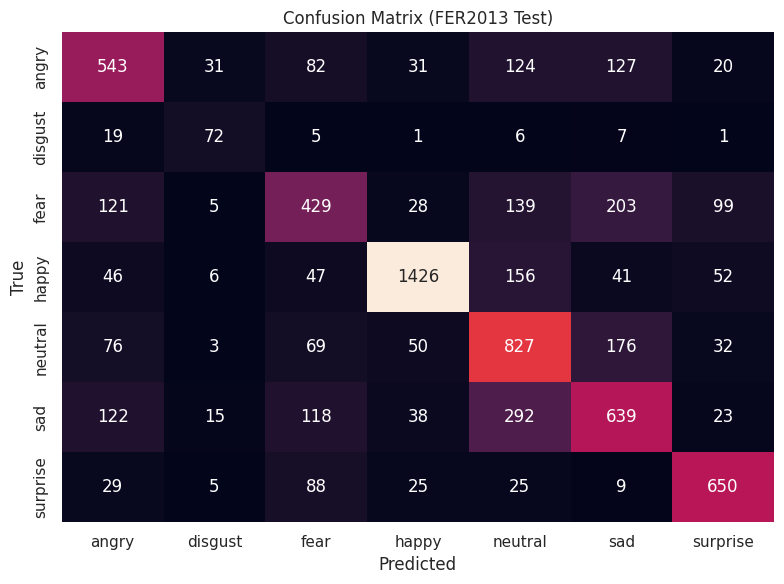

Saved confusion matrix to: /kaggle/working/confusion_matrix.png


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(8,6))
if sns is not None:
    sns.heatmap(cm, annot=True, fmt='d', cmap=None, cbar=False,
                xticklabels=target_names, yticklabels=target_names, ax=ax)
else:
    im = ax.imshow(cm)
    ax.figure.colorbar(im, ax=ax)
    ax.set_xticks(range(len(target_names)))
    ax.set_yticks(range(len(target_names)))
    ax.set_xticklabels(target_names, rotation=45, ha='right')
    ax.set_yticklabels(target_names)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center")

ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix (FER2013 Test)")
fig.tight_layout()

cm_path = KAGGLE_WORK / "confusion_matrix.png"
fig.savefig(cm_path, dpi=150)
plt.show()
plt.close(fig)
print("Saved confusion matrix to:", cm_path)


In [ ]:
summary = {
    "model_path": str(model_path),
    "input_shape": [int(H), int(W), int(C)],
    "classes": target_names,
    "support": int(len(y_true)),
    "accuracy": float((y_true == y_pred).mean()),
    "dataset_kind": "directory(test)"
}
out_json = KAGGLE_WORK / "eval_summary.json"
with open(out_json, "w") as f:
    json.dump(summary, f, indent=2)

print("Saved summary to:", out_json)
summary


Saved summary to: /kaggle/working/eval_summary.json


{'model_path': '/kaggle/input/alexnet-fer2013-keras/keras/default/1/alexnet_fer2013.keras',
 'input_shape': [227, 227, 3],
 'classes': ['angry',
  'disgust',
  'fear',
  'happy',
  'neutral',
  'sad',
  'surprise'],
 'support': 7178,
 'accuracy': 0.6388966285873502,
 'dataset_kind': 'directory(test)'}

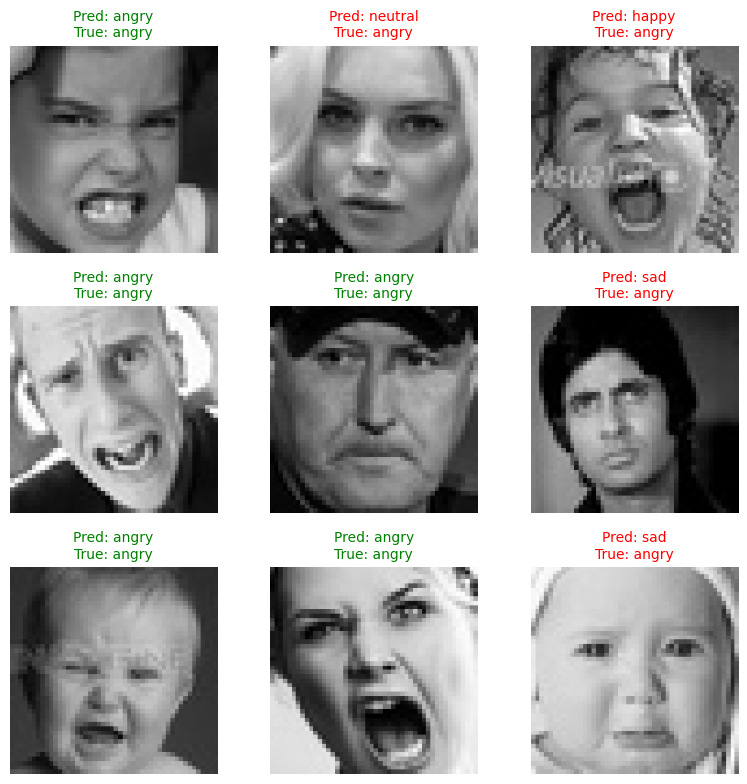

Saved preview to: /kaggle/working/preview_preds.png


In [ ]:
batch_x, batch_y = next(iter(test_gen))
probs = model.predict(batch_x, verbose=0)
preds = np.argmax(probs, axis=1)
true = np.argmax(batch_y, axis=1)

n = min(9, len(batch_x))
plt.figure(figsize=(8,8))

for i in range(n):
    plt.subplot(3,3,i+1)
    img = batch_x[i]
    if img.shape[-1] == 1:
        plt.imshow(img.squeeze(-1), cmap='gray')
    else:
        plt.imshow(img)
    
    pred_label = target_names[preds[i]]
    true_label = target_names[true[i]]
    

    color = "green" if preds[i] == true[i] else "red"
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color, fontsize=10)
    plt.axis('off')

plt.tight_layout()
preview_path = KAGGLE_WORK / "preview_preds.png"
plt.savefig(preview_path, dpi=120)
plt.show()  
print("Saved preview to:", preview_path)
